## CLASSIFICAÇÃO IRIS ARROZ FEIJÃO CARNE MOÍDA E PURE

### PARAMETROS

In [92]:
# PARÂMETROS
random_seed = 42

# FEATURE SELECTION
center_stat = 'mean'

# KNN
k_min = 1
k_max = 11
distance_metric = 'euclidean'
weights = 'uniform'
holdout_size = 0.2
k_of_k_folds = 5

# GOURMET
palette = ['limegreen', 'indianred', 'gold']

In [93]:
from typing import Optional

import numpy
import pandas
import seaborn
from matplotlib import pyplot
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### IMPORT IRIS

In [94]:
iris_dict = load_iris()
iris = pandas.DataFrame(iris_dict['data'])
iris.columns = iris_dict['feature_names']
iris.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
iris['target'] = iris_dict['target']
iris['species'] = iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

iris

,sepal_length,sepal_width,petal_length,petal_width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


### PAIRPLOT

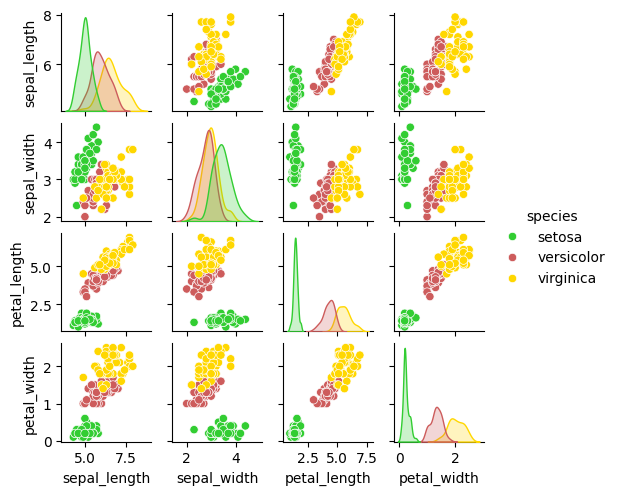

In [95]:
_ = seaborn.pairplot(iris[["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]], hue='species', palette=palette, height=1.25)

### SELEÇÃO DO TOP 2 ATRIBUTOS

In [96]:
all_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
centers = iris.groupby(['species'])[all_cols].agg(center_stat).T
max_diff = (centers.T.max() - centers.T.min()).sort_values(ascending=False)

max_diff

petal_length    4.090
petal_width     1.780
sepal_length    1.582
sepal_width     0.658
dtype: float64

In [97]:
x_cols_sorted = max_diff.index.tolist()[:2]

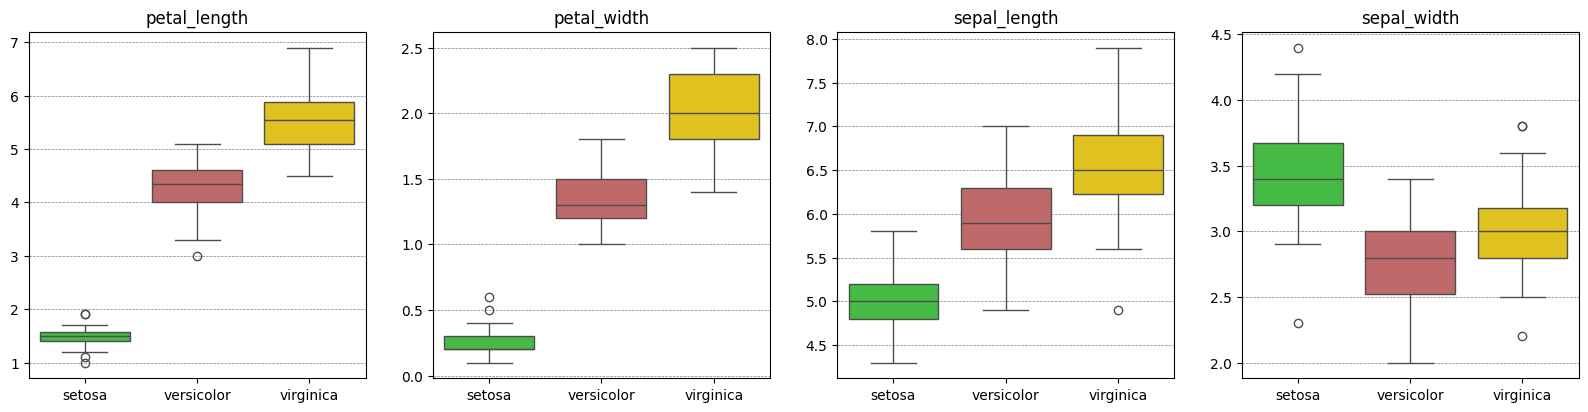

In [98]:
x_cols_sorted = max_diff.index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs.flatten()):
    seaborn.boxplot(x='species', y=x_cols_sorted[i], data=iris, ax=ax, hue='species', dodge=False, palette=palette)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(x_cols_sorted[i])
    ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

In [99]:
x_cols = x_cols_sorted[:2]

x_cols

['petal_length', 'petal_width']

### LOOP DE TREINAMENTO

> TRAINING SIZE VS KNN (MÚLTIPLOS KS) VS REGRESSÃO LOGÍSTICA

In [100]:
# RANDOM SEED
numpy.random.seed(random_seed)

# SEPARAR 20% DOS DADOS COMO HOLDOUT
iris_train : Optional[pandas.DataFrame] = None
iris_test : Optional[pandas.DataFrame] = None
iris_train, iris_test = train_test_split(iris, test_size=holdout_size, stratify=iris['target'], random_state=random_seed)

# LOOP DE TREINAMENTO
ks = range(k_max, k_min - 2, -2)
database_size_range = numpy.arange(0.25, 1.25, 0.25)

# LOOP DE TREINO
# PARA TODOS OS Ks, PARA FEATURES DE 1 A 4 E PARA TODOS OS FOLDS
ix_model = 0
model_list = []
for db_size in database_size_range:
    if db_size != 1.0:
        iris_sample, _ = train_test_split(iris_train, test_size=1.0 - db_size, stratify=iris_train['target'], random_state=random_seed)
    else:
        iris_sample = iris_train
    kfolds = StratifiedKFold(n_splits=k_of_k_folds, shuffle=True, random_state=random_seed)
    ix_fold = 0
    for train_ix, val_ix in kfolds.split(iris_sample[x_cols], iris_sample['target']):
        X_train, y_train = iris_sample[x_cols].iloc[train_ix], iris_sample['target'].iloc[train_ix]
        X_val, y_val = iris_sample[x_cols].iloc[val_ix], iris_sample['target'].iloc[val_ix]

        # ESCALONAMENTO
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # TREINAMENTO KNN
        for k in ks:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric, weights=weights)
            knn.fit(X_train_scaled, y_train)
            y_train_pred = knn.predict(X_train_scaled)
            y_val_pred = knn.predict(X_val_scaled)
            train_accuracy = accuracy_score(y_train, y_train_pred)
            val_accuracy = accuracy_score(y_val, y_val_pred)
            algorithm = 'KNN'
            model_name = f"KNN-{str(k).zfill(2)}-{100.0*db_size:.0f}-{ix_fold}"
            print(f"{model_name} > treino: {100.0*train_accuracy:.1f}% | val: {100.0*val_accuracy:.1f}%")

            model_list.append({'ix_model': ix_model,
                               'algorithm': algorithm,
                               'hyperparameter': k,
                               'db_size': db_size,
                               'hdb' : f"K{str(k).zfill(2)}{100.0*db_size:.0f}",
                               'fold': ix_fold,
                               'model_name': model_name,
                               'stat' : 'train',
                               'accuracy': accuracy_score(y_train, y_train_pred),
                               'scaler' : scaler,
                               'model' : knn})
            model_list.append({'ix_model': ix_model,
                               'algorithm': algorithm,
                               'hyperparameter': k,
                               'db_size': db_size,
                               'hdb' : f"K{str(k).zfill(2)}{100.0*db_size:.0f}",
                               'fold': ix_fold,
                               'model_name': model_name,
                               'stat' : 'validation',
                               'accuracy': accuracy_score(y_val, y_val_pred),
                               'scaler' : scaler,
                               'model' : knn})
            ix_model += 1
        
        # TREINAMENTO LOGISTIC REGRESSION
        logreg = LogisticRegression(penalty=None,
                                    dual=False,
                                    class_weight='balanced',
                                    random_state=random_seed,
                                    solver='lbfgs',
                                    max_iter=1000)
        logreg.fit(X_train_scaled, y_train)
        y_train_pred = logreg.predict(X_train_scaled)
        y_val_pred = logreg.predict(X_val_scaled)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        algorithm = 'LGR'
        model_name = f"LGR-00-{100.0*db_size:.0f}-{ix_fold}"
        print(f"{model_name} > treino: {100.0*train_accuracy:.1f}% | val: {100.0*val_accuracy:.1f}%")

        model_list.append({'ix_model': ix_model,
                           'algorithm': algorithm,
                           'hyperparameter': None,
                           'db_size': db_size,
                           'hdb' : f"L00{100.0*db_size:.0f}",
                           'fold': ix_fold,
                           'model_name': model_name,
                           'stat' : 'train',
                           'accuracy': accuracy_score(y_train, y_train_pred),
                           'scaler' : scaler,
                           'model' : logreg})
        model_list.append({'ix_model': ix_model,
                           'algorithm': algorithm,
                           'hyperparameter': None,
                           'db_size': db_size,
                           'hdb' : f"L00{100.0*db_size:.0f}",
                           'fold': ix_fold,
                           'model_name': model_name,
                           'stat' : 'validation',
                           'accuracy': accuracy_score(y_val, y_val_pred),
                           'scaler' : scaler,
                           'model' : logreg})
        ix_model += 1

        ix_fold += 1


KNN-11-25-0 > treino: 100.0% | val: 100.0%
KNN-09-25-0 > treino: 100.0% | val: 100.0%
KNN-07-25-0 > treino: 100.0% | val: 100.0%
KNN-05-25-0 > treino: 100.0% | val: 100.0%
KNN-03-25-0 > treino: 100.0% | val: 100.0%
KNN-01-25-0 > treino: 100.0% | val: 100.0%
LGR-00-25-0 > treino: 100.0% | val: 100.0%
KNN-11-25-1 > treino: 95.8% | val: 83.3%
KNN-09-25-1 > treino: 100.0% | val: 100.0%
KNN-07-25-1 > treino: 100.0% | val: 100.0%
KNN-05-25-1 > treino: 100.0% | val: 100.0%
KNN-03-25-1 > treino: 100.0% | val: 100.0%
KNN-01-25-1 > treino: 100.0% | val: 100.0%
LGR-00-25-1 > treino: 100.0% | val: 100.0%
KNN-11-25-2 > treino: 100.0% | val: 100.0%
KNN-09-25-2 > treino: 100.0% | val: 100.0%
KNN-07-25-2 > treino: 100.0% | val: 100.0%
KNN-05-25-2 > treino: 100.0% | val: 100.0%
KNN-03-25-2 > treino: 100.0% | val: 100.0%
KNN-01-25-2 > treino: 100.0% | val: 100.0%
LGR-00-25-2 > treino: 100.0% | val: 100.0%
KNN-11-25-3 > treino: 91.7% | val: 100.0%
KNN-09-25-3 > treino: 100.0% | val: 100.0%
KNN-07-25-3 > 

In [101]:
results = pandas.DataFrame(model_list)
results

,ix_model,algorithm,hyperparameter,db_size,hdb,fold,model_name,stat,accuracy,scaler,model
0,0,KNN,11.0,0.25,K1125,0,KNN-11-25-0,train,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
1,0,KNN,11.0,0.25,K1125,0,KNN-11-25-0,validation,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
2,1,KNN,9.0,0.25,K0925,0,KNN-09-25-0,train,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
3,1,KNN,9.0,0.25,K0925,0,KNN-09-25-0,validation,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4,2,KNN,7.0,0.25,K0725,0,KNN-07-25-0,train,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
...,...,...,...,...,...,...,...,...,...,...,...
275,137,KNN,3.0,1.00,K03100,4,KNN-03-100-4,validation,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
276,138,KNN,1.0,1.00,K01100,4,KNN-01-100-4,train,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
277,138,KNN,1.0,1.00,K01100,4,KNN-01-100-4,validation,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
278,139,LGR,NaN,1.00,L00100,4,LGR-00-100-4,train,1.000000,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."


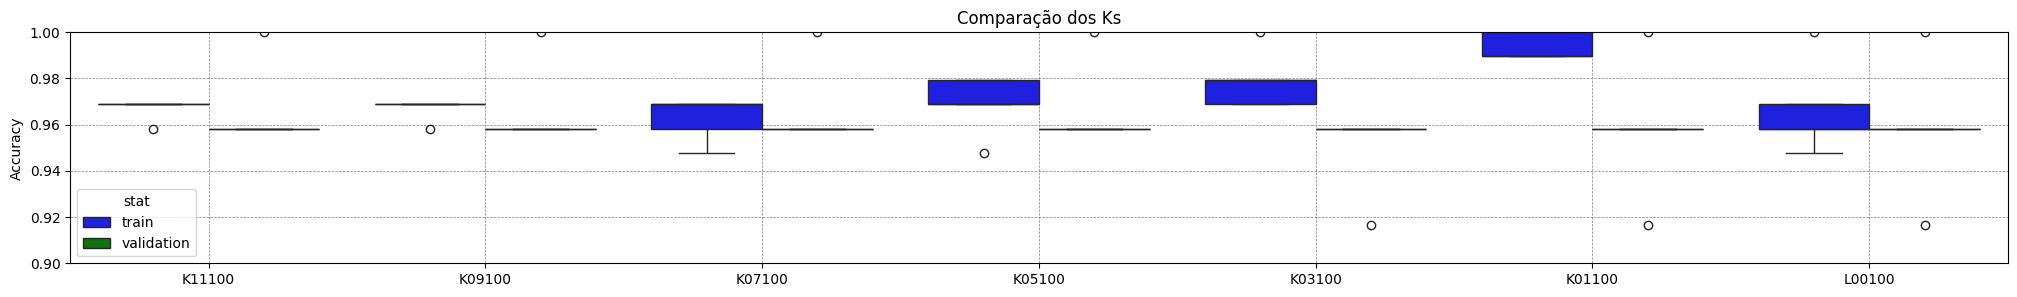

In [102]:
fig = pyplot.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='hdb', y='accuracy', data=results.loc[results.db_size == 1, :], hue='stat', palette=['blue', 'green'], ax=ax, hue_order=['train', 'validation'])
ax.set_title('Comparação dos Ks')
ax.set_ylabel('Accuracy')
ax.set_xlabel('')
ax.set_ylim(0.9, 1.0)
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

### PICK DO MELHOR K

In [103]:
ix_validation = results["stat"] == "validation"
ix_knn = results["algorithm"] == "KNN"
ix_dbsize = results["db_size"] == 1.0
ix_best_k = ix_validation & ix_knn & ix_dbsize

mean_accuracy_by_kf = results.loc[ix_best_k, ["hyperparameter", "hdb", "accuracy"]].groupby(["hyperparameter", "hdb"]).agg(["mean", "min"]).reset_index()
mean_accuracy_by_kf.columns = ['h', 'hdb', 'mean_accuracy', 'min_accuracy']
mean_accuracy_by_kf = mean_accuracy_by_kf.sort_values(by=['h', 'mean_accuracy', 'min_accuracy'], ascending=[False, False, False])
mean_accuracy_by_kf

,h,hdb,mean_accuracy,min_accuracy
5,11.0,K11100,0.966667,0.958333
4,9.0,K09100,0.966667,0.958333
3,7.0,K07100,0.966667,0.958333
2,5.0,K05100,0.966667,0.958333
1,3.0,K03100,0.950000,0.916667
0,1.0,K01100,0.958333,0.916667


### RETREINO MELHOR K

In [ ]:
best_k = mean_accuracy_by_kf.iloc[0, :]['h']
# RETRAIN MODEL WITH ALL TRAINING + VALIDATION
best_k_scaler = StandardScaler()
X_best_k_scaled = best_k_scaler.fit_transform(iris_train[x_cols])
y_best_k = iris_train['target']
best_k_knn = KNeighborsClassifier(n_neighbors=int(best_k), metric=distance_metric, weights=weights)
best_k_knn.fit(X_best_k_scaled, y_best_k)
y_best_k_pred = best_k_knn.predict(X_best_k_scaled)
knn_retrain_accuracy = accuracy_score(y_best_k, y_best_k_pred)
print(f"Modelo KNN retreinado com K={best_k} > treino: {100.0*train_accuracy:.1f}%")

Modelo KNN retreinado com K=11.0 > treino: 96.7%


### RETREINO REGRESSÃO LOGÍSTICA

In [ ]:
reg_log_scaler = StandardScaler()
X_reg_log_scaled = reg_log_scaler.fit_transform(iris_train[x_cols])
y_reg_log = iris_train['target']

retrain_logreg = LogisticRegression(penalty=None,
                                    dual=False,
                                    class_weight='balanced',
                                    random_state=random_seed,
                                    solver='lbfgs',
                                    max_iter=1000)
retrain_logreg.fit(X_reg_log_scaled, y_reg_log)
y_reg_log_pred = retrain_logreg.predict(X_reg_log_scaled)
log_reg_retrain_accuracy = accuracy_score(y_reg_log, y_reg_log_pred)

print(f"Modelo LGR retreinado > treino: {100.0*train_accuracy:.1f}%")

Modelo LGR retreinado > treino: 95.8%


### CANDIDATOS: RETREINOS + MELHOR FOLDS

In [118]:
# best_k_knn, retrain_logreg

best_k_fold_row = results.loc[(results.db_size == 1.0) & (results.algorithm == "KNN") & (results.hyperparameter == best_k) & (results["stat"] == "validation"), :].sort_values(by='accuracy', ascending=False).iloc[0, :]
best_k_fold_scaler = best_k_fold_row['scaler']
best_k_fold_knn = best_k_fold_row['model']

In [119]:
best_logreg_fold_row = results.loc[(results.db_size == 1.0) & (results.algorithm == "LGR") & (results["stat"] == "validation"), :].sort_values(by='accuracy', ascending=False).iloc[0, :]
best_logreg_fold_scaler = best_logreg_fold_row['scaler']
best_logreg_fold_lgr = best_logreg_fold_row['model']

best_logreg_fold_lgr


LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

### ERRO HOLDOUT ERRO ALL PARA OS CANDIDATOS

In [123]:
candidate_models = [("KNN", "RETRAIN", best_k_scaler, best_k_knn), 
                    ("LGR", "RETRAIN", reg_log_scaler, retrain_logreg),
                    ("KNN", "FOLD", best_k_fold_scaler, best_k_fold_knn),
                    ("LGR", "FOLD", best_logreg_fold_scaler, best_logreg_fold_lgr)]

# CALCULATE HOLDOUT AND ALL ACCURACY
holdout_results = []
for algorithm, config, scaler, model in candidate_models:
    X_test_scaled = scaler.transform(iris_test[x_cols])
    y_test = iris_test['target']
    X_all_scaled = scaler.transform(iris[x_cols])
    y_all = iris['target']
    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    y_all_pred = model.predict(X_all_scaled)
    all_accuracy = accuracy_score(y_all, y_all_pred)
    holdout_results.append({'algorithm': algorithm,
                            'config': config,
                            'stat': 'holdout',
                            'accuracy': test_accuracy,
                            'model': model,
                            'scaler': scaler})
    holdout_results.append({'algorithm': algorithm,
                            'config': config,
                            'stat': 'all',
                            'accuracy': all_accuracy,
                            'model': model,
                            'scaler': scaler})
    
holdout_results = pandas.DataFrame(holdout_results)
holdout_results = holdout_results.sort_values(by='accuracy', ascending=False)
holdout_results

,algorithm,config,stat,accuracy,model,scaler
2,LGR,RETRAIN,holdout,0.966667,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
6,LGR,FOLD,holdout,0.966667,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
3,LGR,RETRAIN,all,0.960000,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
1,KNN,RETRAIN,all,0.960000,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
7,LGR,FOLD,all,0.960000,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
5,KNN,FOLD,all,0.960000,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
0,KNN,RETRAIN,holdout,0.933333,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
4,KNN,FOLD,holdout,0.933333,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()


### PICK DO MELHOR MODELO

In [133]:
best_model_row = holdout_results.loc[holdout_results['stat'] == 'holdout', :].sort_values(by='accuracy', ascending=False).iloc[0, :]
best_model_row

algorithm                                                  LGR
config                                                 RETRAIN
stat                                                   holdout
accuracy                                              0.966667
model        LogisticRegression(class_weight='balanced', ma...
scaler                                        StandardScaler()
Name: 2, dtype: object

In [134]:
best_model = best_model_row['model']
best_model_scaler = best_model_row['scaler']

print(f"Melhor modelo: {best_model_row['algorithm']} - {best_model_row['config']} > holdout: {100.0*best_model_row['accuracy']:.1f}%, all: {100.0*holdout_results.loc[holdout_results['stat'] == 'all', 'accuracy'].max():.1f}%")

Melhor modelo: LGR - RETRAIN > holdout: 96.7%, all: 96.0%


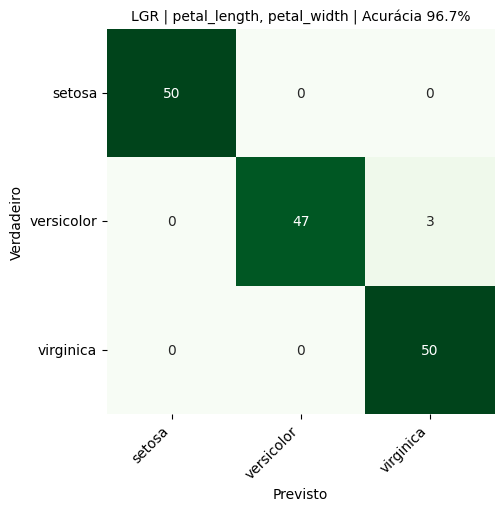

In [136]:
Xs = best_model_scaler.transform(iris[x_cols])
y = iris['target']
winner_y_pred = knn.predict(Xs)


fig = pyplot.figure(figsize=(5, 5))
# PLOT CONFUSION MATRIX
conf_matrix = confusion_matrix(y, winner_y_pred)

ax = fig.add_subplot(111)
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, ax=ax)
_ = ax.set_xlabel('Previsto')
_ = ax.set_ylabel('Verdadeiro')
_ = ax.set_xticklabels(iris['species'].unique(), rotation=45, ha='right')
_ = ax.set_yticklabels(iris['species'].unique(), rotation=0, ha='right')
# _ = ax.set_title(f'Vencedor: {winner.fk} | treino {100.0*winner_train_accuracy:.0f}% | teste {100.0*winner.hit:.0f}%')
best_feat_string = ', '.join(x_cols)
_ = ax.set_title(f'{best_model_row['algorithm']} | {best_feat_string} | Acurácia {100.0*best_model_row['accuracy']:.1f}%', size=10)

CONFUSÃO + ROC + SUPERFÍCIE DE SEPARAÇÃO MELHOR MODELO

LEARNING CURVE MELHOR K VS REGRESSÃO LOGÍSTICA

FLUTUAÇÃO DOS PARÂMETROS DA REGRESSÃO LOGÍSTICA